## Part 1 - Pure Python


This section implements multivariable linear regression using only core Python.
It includes manual feature normalization, gradient descent optimization, and evaluation without using any external libraries like NumPy or Pandas.
The implementation is educational and shows how linear regression works under the hood, but is not optimized for speed.

Skipping row ['-122.16', '37.77', '47.0', '1256.0', '', '570.0', '218.0', '4.375', '161900.0', 'NEAR BAY'] — could not convert string to float: ''
Skipping row ['-122.17', '37.75', '38.0', '992.0', '', '732.0', '259.0', '1.6196', '85100.0', 'NEAR BAY'] — could not convert string to float: ''
Skipping row ['-122.28', '37.78', '29.0', '5154.0', '', '3741.0', '1273.0', '2.5762', '173400.0', 'NEAR BAY'] — could not convert string to float: ''
Skipping row ['-122.24', '37.75', '45.0', '891.0', '', '384.0', '146.0', '4.9489', '247100.0', 'NEAR BAY'] — could not convert string to float: ''
Skipping row ['-122.1', '37.69', '41.0', '746.0', '', '387.0', '161.0', '3.9063', '178400.0', 'NEAR BAY'] — could not convert string to float: ''
Skipping row ['-122.14', '37.67', '37.0', '3342.0', '', '1635.0', '557.0', '4.7933', '186900.0', 'NEAR BAY'] — could not convert string to float: ''
Skipping row ['-121.77', '39.66', '20.0', '3759.0', '', '1705.0', '600.0', '4.712', '158600.0', 'INLAND'] — could n

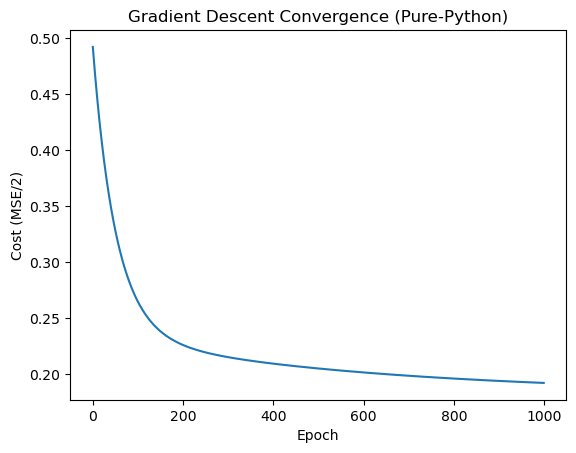

In [1]:
import csv
import random
import math
import time
import matplotlib.pyplot as plt

def load_data(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        cat_idx = header.index("ocean_proximity")
        target_idx = len(header) - 1

        numeric_header = [
            col for i, col in enumerate(header)
            if i != cat_idx
        ]
        data = []
        for row in reader:
            numeric_row = [x for i, x in enumerate(row) if i != cat_idx]
            try:
                float_row = list(map(float, numeric_row))
                data.append(float_row)
            except ValueError as e:
                print(f"Skipping row {row} — {e}")
                continue

    return data, numeric_header

def normalize_data(data):
    cols = list(zip(*data))
    means = [sum(col) / len(col) for col in cols]
    stds = [math.sqrt(sum((x - mean) ** 2 for x in col) / len(col)) for col, mean in zip(cols, means)]
    norm_data = [[(x - mean) / std if std != 0 else 0 for x, mean, std in zip(row, means, stds)] for row in data]
    return norm_data, means, stds

def train_val_split(data, val_ratio=0.2):
    random.shuffle(data)
    split = int(len(data) * (1 - val_ratio))
    return data[:split], data[split:]

def predict(x, weights, bias):
    return sum(w * xi for w, xi in zip(weights, x)) + bias

def compute_cost(data, weights, bias):
    total_cost = 0
    for row in data:
        x, y = row[:-1], row[-1]
        pred = predict(x, weights, bias)
        total_cost += (pred - y) ** 2
    return total_cost / (2 * len(data))

def gradient_descent(train_data, lr=0.01, epochs=1000):
    n_features = len(train_data[0]) - 1
    weights = [0.0] * n_features
    bias = 0.0
    cost_history = []
    
    start_time = time.time()
    for epoch in range(epochs):
        dw = [0.0] * n_features
        db = 0.0

        for row in train_data:
            x, y = row[:-1], row[-1]
            pred = predict(x, weights, bias)
            error = pred - y
            for i in range(n_features):
                dw[i] += error * x[i]
            db += error

        m = len(train_data)
        weights = [w - lr * (dw[i] / m) for i, w in enumerate(weights)]
        bias -= lr * (db / m)

        cost = compute_cost(train_data, weights, bias)
        cost_history.append(cost)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Cost: {cost:.4f}")
    
    total_time = time.time() - start_time
    return weights, bias, cost_history , total_time

def evaluate(data, weights, bias):
    errors = []
    y_true = []
    y_pred = []

    for row in data:
        x, y = row[:-1], row[-1]
        pred = predict(x, weights, bias)
        y_true.append(y)
        y_pred.append(pred)
        errors.append(pred - y)

    mae = sum(abs(e) for e in errors) / len(errors)
    rmse = math.sqrt(sum(e**2 for e in errors) / len(errors))
    mean_y = sum(y_true) / len(y_true)
    r2 = 1 - (sum((yt - yp)**2 for yt, yp in zip(y_true, y_pred)) / sum((yt - mean_y)**2 for yt in y_true))

    return mae, rmse, r2

if __name__ == "__main__":
    filename = "housing.csv"
    raw_data, header = load_data(filename)
    norm_data, means, stds = normalize_data(raw_data)
    train_data, val_data = train_val_split(norm_data)

    weights, bias, cost_history , time_taken = gradient_descent(train_data, lr=0.01, epochs=1000)
    print(f"\n[NumPy] Training time: {time_taken:.3f} seconds")
    print("Final weights:", weights)
    print("Final bias:", bias)
    
    mae, rmse, r2 = evaluate(val_data, weights, bias)
    print(f"\nEvaluation on validation set:\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2 Score: {r2:.4f}")


    plt.plot(cost_history)
    plt.xlabel("Epoch")
    plt.ylabel("Cost (MSE/2)")
    plt.title("Gradient Descent Convergence (Pure‑Python)")
    plt.show()



## Part 2 - NumPy


Here, we re-implement the linear regression using NumPy.
All operations such as matrix multiplication, gradient calculation, and loss computation are vectorized.
This version is significantly faster than pure Python due to optimized array operations.

In [2]:
import csv
import time
import numpy as np

def load_numeric_data(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        cat_idx = header.index("ocean_proximity")
        num_indices = [i for i in range(len(header)) if i != cat_idx]

    data = np.genfromtxt(
        filename, delimiter=',', skip_header=1,
        usecols=num_indices,  
        filling_values=np.nan
    )
    data = data[~np.isnan(data).any(axis=1)]
    return data, [header[i] for i in num_indices]

def normalize_features(X):
    means = X.mean(axis=0)
    stds  = X.std(axis=0)
    X_norm = (X - means) / stds
    return X_norm, means, stds

def train_val_split(X, y, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    m = X.shape[0]
    idx = np.random.permutation(m)
    split = int(m * (1 - val_ratio))
    train_idx, val_idx = idx[:split], idx[split:]
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

def compute_cost_vec(X, y, w, b):
    m = X.shape[0]
    errors = X.dot(w) + b - y
    return (errors @ errors) / (2 * m)

def gradient_descent_vec(X, y, lr=0.01, epochs=1000):
    m, n = X.shape
    w = np.zeros(n)
    b = 0.0
    cost_history = np.zeros(epochs)

    start_time = time.time()
    for epoch in range(epochs):
        preds = X.dot(w) + b
        error = preds - y

        dw = (X.T @ error) / m
        db = error.sum() / m

        w -= lr * dw
        b -= lr * db

        cost_history[epoch] = (error @ error) / (2 * m)

        if epoch % 100 == 0:
            print(f"[NumPy] Epoch {epoch}, Cost: {cost_history[epoch]:.4f}")

    total_time = time.time() - start_time
    return w, b, cost_history, total_time

def evaluate_metrics(X, y, w, b):
    preds = X.dot(w) + b
    errors = preds - y
    mae  = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    r2   = 1 - (errors @ errors) / ((y - y.mean()) @ (y - y.mean()))
    return mae, rmse, r2

if __name__ == "__main__":
    data, cols = load_numeric_data("housing.csv")
    X_raw, y_raw = data[:, :-1], data[:, -1]

    X_norm, means, stds = normalize_features(X_raw)

    y_mean, y_std = y_raw.mean(), y_raw.std()
    y_norm = (y_raw - y_mean) / y_std

    X_train, y_train, X_val, y_val = train_val_split(X_norm, y_norm)

    w_np, b_np, cost_hist_np, time_np = gradient_descent_vec(
        X_train, y_train, lr=0.01, epochs=1000
    )
    print(f"\n[NumPy] Training time: {time_np:.3f} seconds")

    mae_np, rmse_np, r2_np = evaluate_metrics(X_val, y_val, w_np, b_np)

    mae_dollars  = mae_np * y_std
    rmse_dollars = rmse_np * y_std

    print(f"\n[NumPy] Validation MAE (norm):        {mae_np:.4f}")
    print(f"[NumPy] Validation RMSE (norm):      {rmse_np:.4f}")
    print(f"[NumPy] Validation R²:               {r2_np:.4f}")
    print(f"[NumPy] Validation MAE (dollars):    {mae_dollars:.2f}")
    print(f"[NumPy] Validation RMSE (dollars):   {rmse_dollars:.2f}")



[NumPy] Epoch 0, Cost: 0.5008
[NumPy] Epoch 100, Cost: 0.2661
[NumPy] Epoch 200, Cost: 0.2271
[NumPy] Epoch 300, Cost: 0.2162
[NumPy] Epoch 400, Cost: 0.2104
[NumPy] Epoch 500, Cost: 0.2060
[NumPy] Epoch 600, Cost: 0.2024
[NumPy] Epoch 700, Cost: 0.1993
[NumPy] Epoch 800, Cost: 0.1968
[NumPy] Epoch 900, Cost: 0.1947

[NumPy] Training time: 0.255 seconds

[NumPy] Validation MAE (norm):        0.4547
[NumPy] Validation RMSE (norm):      0.6217
[NumPy] Validation R²:               0.6111
[NumPy] Validation MAE (dollars):    52489.45
[NumPy] Validation RMSE (dollars):   71761.78


## Part 3 - scikit-learn


This section uses scikit-learn’s built-in `LinearRegression` class to fit the model.
It does not use gradient descent but instead solves the normal equation directly.
It's extremely fast and efficient, making it ideal for practical use cases where performance matters more than learning how the algorithm works.

In [3]:
import csv
import time
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

def load_numeric_data(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        cat_idx = header.index("ocean_proximity")
        num_indices = [i for i in range(len(header)) if i != cat_idx]
    data = np.genfromtxt(
        filename, delimiter=',', skip_header=1,
        usecols=num_indices,
        filling_values=np.nan
    )
    return data[~np.isnan(data).any(axis=1)], [header[i] for i in num_indices]

def normalize_features(X):
    means = X.mean(axis=0)
    stds  = X.std(axis=0)
    return (X - means) / stds, means, stds

def train_val_split(X, y, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    m = X.shape[0]
    idx = np.random.permutation(m)
    split = int(m * (1 - val_ratio))
    return X[idx[:split]], y[idx[:split]], X[idx[split:]], y[idx[split:]]

if __name__ == "__main__":
    data, cols = load_numeric_data("housing.csv")
    X_raw, y_raw = data[:, :-1], data[:, -1]

    X, feat_means, feat_stds = normalize_features(X_raw)
    y_mean, y_std = y_raw.mean(), y_raw.std()
    y = (y_raw - y_mean) / y_std

    X_train, y_train, X_val, y_val = train_val_split(X, y)

    model = LinearRegression()
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    y_pred_norm = model.predict(X_val)
    mae_norm   = mean_absolute_error(y_val, y_pred_norm)
    rmse_norm  = root_mean_squared_error(y_val, y_pred_norm)
    r2         = r2_score(y_val, y_pred_norm)

    mae_doll  = mae_norm * y_std
    rmse_doll = rmse_norm * y_std

    print(f"\n[sklearn] Fit time: {fit_time:.4f} s")
    print(f"[sklearn] Validation MAE (norm):   {mae_norm:.4f}")
    print(f"[sklearn] Validation RMSE (norm):  {rmse_norm:.4f}")
    print(f"[sklearn] Validation R²:           {r2:.4f}")
    print(f"[sklearn] Validation MAE (dollars):  {mae_doll:.2f}")
    print(f"[sklearn] Validation RMSE (dollars): {rmse_doll:.2f}")



[sklearn] Fit time: 0.0040 s
[sklearn] Validation MAE (norm):   0.4399
[sklearn] Validation RMSE (norm):  0.6006
[sklearn] Validation R²:           0.6370
[sklearn] Validation MAE (dollars):  50774.85
[sklearn] Validation RMSE (dollars): 69327.89


## Regression Metrics Comparison Chart


This final section presents a bar chart comparing MAE, RMSE, and R² values across all three implementations.
It visually highlights the trade-offs in accuracy and helps validate the correctness of each method.

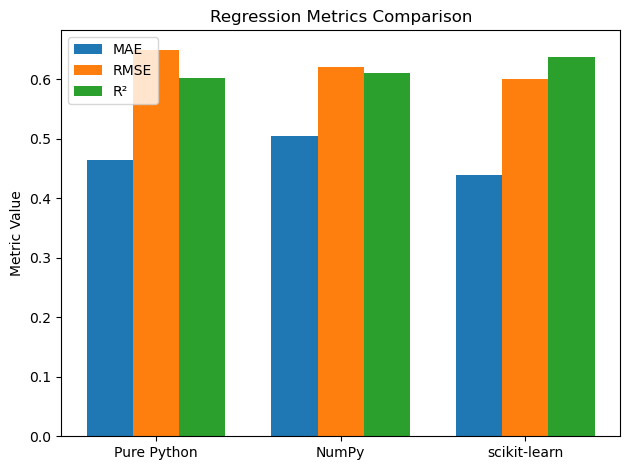

In [4]:

import matplotlib.pyplot as plt
import numpy as np

methods = ['Pure Python', 'NumPy', 'scikit-learn']
mae = [0.4646, 0.5050, 0.4399]
rmse = [0.6498, 0.6200, 0.6006]
r2 = [0.6015, 0.6112, 0.6370]

x = np.arange(len(methods))
width = 0.25

plt.figure()
plt.bar(x - width, mae, width, label='MAE')
plt.bar(x, rmse, width, label='RMSE')
plt.bar(x + width, r2, width, label='R²')
plt.xticks(x, methods)
plt.ylabel('Metric Value')
plt.title('Regression Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()
